# Fit CO2 concentration in atmosphere versus time

We first grab the CO2 data (I put them on the repo to avoid problems with the NOAA server...) and plot them, and try to fit them with different functions (polynomial and power law).

Data are at the address ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt

In [7]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.tri as tri

import numpy as np
import scipy
from scipy.optimize import curve_fit 

import pandas as pd # we need the pandas library, really useful to read excel, csv files, etc...

# We fix the random seed to always get the same problem
np.random.seed(seed=42)

# to deal with uncertainty propagation
import uncertainties
from uncertainties import unumpy as un

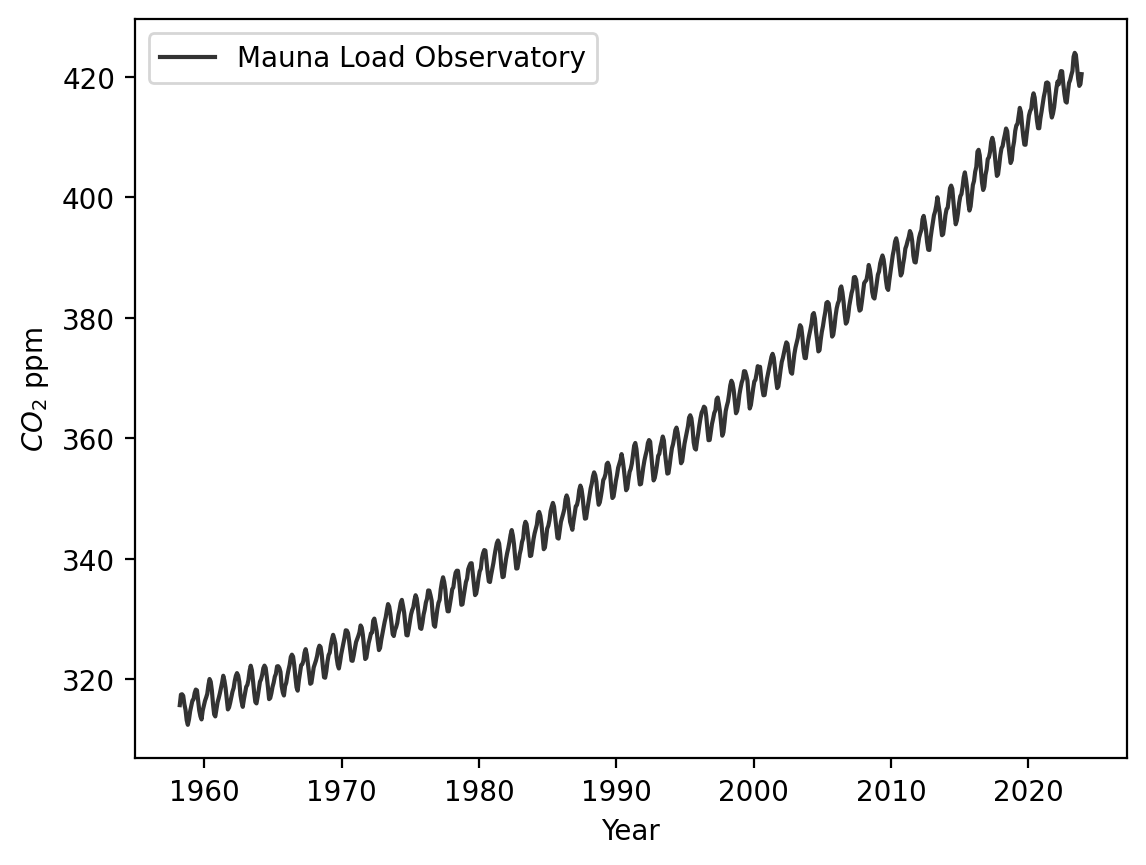

In [8]:
dat = pd.read_table('co2_mm_mlo.txt',
                  comment='#', sep='\s+', header=None, na_values=[-1, -99.99])

# what are the columns? 
dat.columns = ['year', 'month', 'dec_year', 'co2_av', 'co2_interp', '1', '2', '3']

plt.figure(dpi=200)
# let's plot those data

plt.plot(dat.loc[:, 'dec_year'], dat.loc[:, 'co2_av'], c=(0,0,0,0.8), label='Mauna Load Observatory')

plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()

In [9]:
# let's make sure there is no NAN (missing values, happens in various geochemical records!)
dat.dropna(inplace=True)  # necessary because optimisation fails if there are NaNs in the data
x_fit = dat.loc[:, 'dec_year']
y_fit = dat.loc[:, 'co2_av']

# Fit it !

In [10]:
def forward_model(time, p0, p1, p2, p3, phase, amp):
    seasonal = un.sin((time - phase) * (2 * np.pi)) * amp
    return time**3 * p3 + time**2 * p2 + time * p1 + p0 + seasonal


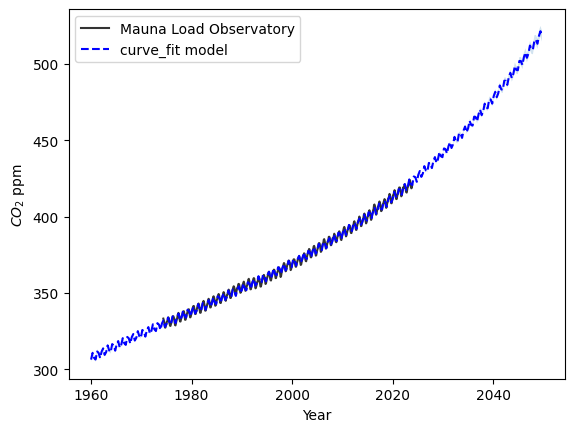

In [23]:
# ajustement du modèle
popt, pcov = curve_fit(forward_model, x_fit, y_fit)

# incertitudes sans covariance
params = uncertainties.correlated_values(popt, pcov)

# prédiction avec incertitudes sans covariance
x_pred = np.arange(1960, 2050, 0.3)
y_pred = forward_model(x_pred, *params)

# plotting the data
plt.plot(x_fit, y_fit, c=(0,0,0,0.8), label='Mauna Load Observatory')

# plotting the model
plt.plot(x_pred,un.nominal_values(y_pred),"b--",label="curve_fit model")

# plotting its error bars
plt.fill_between(x_pred, un.nominal_values(y_pred) - 2*un.std_devs(y_pred),
                 un.nominal_values(y_pred) + 2*un.std_devs(y_pred), alpha=0.2, zorder=-1)

plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()

# Machine learning example

In [85]:
from sklearn.neural_network import MLPRegressor

# Train-test split
# Split fraction
split = int(0.8*len(x_fit))
x_train = x_fit.values[:split]
y_train = y_fit.values[:split]

x_test = x_fit.values[split:]
y_test = y_fit.values[split:]

# scaling the data
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(x_train.reshape(-1,1))  
# apply the transformation on train and test
x_train_sc = scaler.transform(x_train.reshape(-1,1))  
x_test_sc = scaler.transform(x_test.reshape(-1,1))  

regr = MLPRegressor(hidden_layer_sizes=(400, 200, 100, 50),
                    random_state=1).fit(x_train_sc.reshape(-1,1), 
                                                      y_train.reshape(-1,1))

/Users/charleslelosq/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/charleslelosq/anaconda3/envs/ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [86]:
# make prediction on the x_pred variable (do not forget to rescale)
y_pred_nn = regr.predict(scaler.transform(x_pred.reshape(-1,1)))

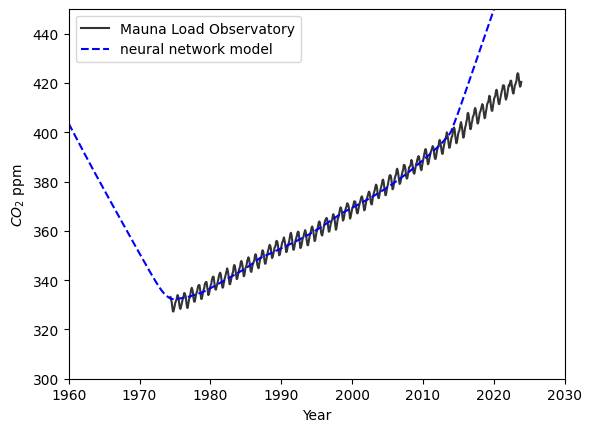

In [87]:
# plotting the data
plt.plot(x_fit, y_fit, c=(0,0,0,0.8), label='Mauna Load Observatory')

# plotting the model
plt.plot(x_pred,y_pred_nn,"b--",label="neural network model")

plt.xlim(1960, 2030)
plt.ylim(300, 450)

plt.xlabel('Year')
plt.ylabel('$CO_2$ ppm')

plt.legend()